#PyTorch Intro - Autoróżniczkowanie i Graf Obliczeń - Laboratorium

Do optymalizacji parametrów (wag) sieci neuronowej podczas treningu modelu wykorzystuje się **metodę stochastycznego spadku wzdłuż gradientu**.
Gradient funkcji straty względem parametrów sieci wyznaczany jest algorytmem **propagacji wstecznej** (*back propagation*).

Sieć neuronową możemy potraktować jak złożoną funkcję mapującą wejściowe dane $x \in \mathcal{X}$ (np. obraz czy sekwencję audio) na wyjście $y \in \mathcal{Y}$ parametryzowaną zestawem parametrów (wag) $\theta$.
$$
f_{\theta}( x ) = y
$$
W przypadku $n$-klasowego klasyfikatora wyjściem z sieci jest wektor $y \in \mathbb{R}^n$ nieznormalizowanych wartości, zwanych logitami, z których możemy wyznaczyć rozkład prawdopodobieństwa klas korzystając z funkcji softmax.

W jednym kroku treningu sieci neuronowych wykonujemy:
1. **Przejście w przód** - przetworzenie zestawu wejściowych danych treningowych przez sieć i wyznaczenie wartości wynikowych $y = f_{\theta}(x)$. Następnie wyznaczenie wartości funkcji straty
$\mathcal{L}$
w oparciu o wynikową wartość z sieci i prawdziwą (docelową) wartość.
2. **Przejście w tył** (propagacja wsteczna) - wyznaczenie **gradientu funkcji  straty** $\mathcal{L}$ **względem parametrów sieci** $\theta$.
3. Krok optymalizacji parametrów sieci - zmiana w kierunku przeciwnym do gradientu.

##Przygotowanie środowiska
Upewnij się, że notatnik jest uruchomiony na maszynie z GPU. Jeśli GPU nie jest dostępne zmień typ maszyny (Runtime | Change runtime type) i wybierz T4 GPU.

In [1]:
!nvidia-smi

Sun Mar 23 14:07:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Biblioteka PyTorch (`torch`) jest domyślnie zainstalowana w środowisku COLAB.

In [2]:
import torch
import numpy as np

print(f"Wersja biblioteki PyTorch: {torch.__version__}")

Wersja biblioteki PyTorch: 2.6.0+cu124


Sprawdzenie dostępnego urządzenia GPU.

In [3]:
print(f"Dostępność GPU: {torch.cuda.is_available()}")
print(f"Typ GPU: {torch.cuda.get_device_name(0)}")

Dostępność GPU: True
Typ GPU: Tesla T4


Instalacja pakietu torchviz do wizualizacji grafów obliczeń ([link](https://github.com/szagoruyko/pytorchviz)).

In [4]:
!pip install -q torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 820.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00


#Automatyczne różniczkowanie (`torch.autograd`)

**Gradient** (lub gradientowe pole wektorowe) funkcji skalarnej wielu zmiennych $
f: \mathbb{R}^D → \mathbb{R}
$ oznaczamyy
$\nabla f$ (czytaj: nabla).
W układzie współrzędnych kartezjańskich gradient jest wektorem, którego składowe są pochodnymi cząstkowymi funkcji $f$:
$$\nabla f=\left[{\frac {\partial f}{\partial x_{1}}},\dots ,{\frac {\partial f}{\partial x_{n}}}\right]$$

Niech $\mathcal{L}: \mathbb{R}^D \rightarrow \mathbb{R}$ będzie pewną funkcją straty określoną dla sieci neuronowej o $D$ parametrach (wagach).
Celem treningu sieci neuronowej jest znalezienie zestawu parametrów $\mathbf{\hat{}} \in \mathbb{R}^D$ minimalizującego wartośc funkcji straty:
$$\mathbf{\hat{w}} = \arg \min_{\textbf{w}} \mathcal{L} \left( \textbf{w} \right)$$
W metodzie **spadku wzdłuż gradientu** zaczynamy od losowo zainicjalizowanych parametrów (wag) sieci $\textbf{w}_0$ a następnie iteracyjnie aktualizujemy parametry sieci w kierunku przeciwnym do wartości gradientu:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla \mathcal{L} \left( \mathbf{w}_t \right)
$$.





Aby wyznaczyć **gradient funkcji straty względem parametrów sieci**, PyTorch posiada wbudowany mechanizm różniczkowania o nazwie `torch.autograd`. Umożliwia on automatyczne obliczanie gradientu dla dowolnego grafu obliczeniowego.

Obiekty typu Tensor posiadają logiczną flagę `requires_grad`.
Domyślnie flaga `requires_grad` jest ustawiana na `False`.
Po jej włączeniu PyTorch będzie automatycznie budował grafy dla wszystkich obliczeń wykonanych z wykorzystaniem tego tensora aby umożliwić automatyczne wyznaczanie gradientu.
Jeśli jeden z argumentów operacji na tensorach ma ustawioną flagę `requires_grad`, wynik również będzie miał ustawioną tę flagę.

#Zadania do wykonania

##Zadanie 1

Niech $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ będzie funkcją:

$$f(x) = sin(x_1) cos(x_2) + sin(0.5 \cdot x_1) cos(0.5 \cdot x_2)$$.

1.   Napisz kod wyznaczających lokalne minimum funkcji $f$ metodą spadku wzdłuż gradientu dla początkowych wartości argumentów $x_1, x_2$ wylosowanych z zakresu $[0; 10]$. Wyświetl znalezione minimum oraz wartości argumentów funcji.
    *   Wykorzystaj mechanizm autoróżniczkowania do wyznaczenia gradientu funkcji $f$. Pamiętaj, aby włączyć budowanie grafu obliczeń dla tensorów `x1` i `x2`.
    *   Liczbę iteracji i stopę uczenia dobierz eksperymentalnie.
    *   Na końcu każdego kroku optymalizacji wyzeruj wartości gradientów każdego z argumentów (`x.grad.zeros_()`). Domyślnie PyTorch akumuluje wartości gradientu dla wielu wywołań przejścia w tył `backward()`.
2.   Zwizualizuj trajektorie parametrów $(x_1, x_2)$ w kolejnych krokach optymalizacji powtarzając cały proces kilkakrotnie, rozpoczynając od losowo wybranych wartości argumentów, każdy z zakresu $[0; 10]$. Czy za każdym razem osiągane jest to samo lokalne minimum?
3.   (opcjonalnie) Zaimplementuj zwektoryzowaną wersję procedury wykonującej minimalizację wartości funkcji $f$ dla wielu zestawów argumentów wejściowych danych jako macierz (tensor) o wymiarach $(n,2)$.
   *   Zwektoryzowana wersja nie zawiera pętli przechodzącej po każdym z $n$ zestawów argumentów. W jednym kroku optymalizacji aktualizuje wszystkie $n$ zestawów argumentów.
   *   Aby wyznaczyć gradient dla każdego elementu z osobna tensora który nie jest skalarem, np. dla $n$-elementowego wektora `f` zawierającego wyniki obliczeń dla $n$ zestawów argumentów, jako argument metody `backward` podaj tensor jedynek o rozmiarze równym rozmiarowi `f`, np. `f.backward(torch.ones_like(f))`.

Wizualizacja funkcji $f(x)$ z wykorzystaniem biblioteki Plotly.

In [8]:
import numpy as np
import plotly.graph_objects as go

# Utwórz siatkę wartości x i y
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y) + np.sin(0.5 * X) * np.cos(0.5 * Y)

fig = go.Figure(data=go.Contour(z=Z, x=x, y=y, colorscale='Viridis'))
fig.update_layout(title="Izolinie funkcji 3D", xaxis_title="X", yaxis_title="Y")
fig.show()

In [6]:
fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y, colorscale='Viridis')])
fig.update_layout(
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
fig.show()

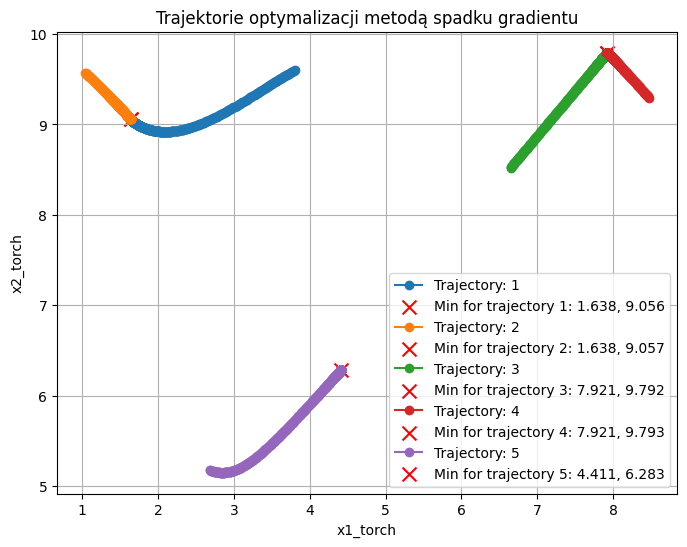

In [23]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

learning_rate = 0.015
num_iterations = 700
start_counter = 5 # z tylu różnych puntków startujemy szukanie minimum

plt.figure(figsize=(8, 6))

def f(x1, x2):
    return torch.sin(x1) * torch.cos(x2) + torch.sin(0.5 * x1) * torch.cos(0.5 * x2)

# Utwórz siatkę wartości x i y
x = np.linspace(0, 15, 100)
y = np.linspace(0, 15, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y) + np.sin(0.5 * X) * np.cos(0.5 * Y)

fig = go.Figure()
fig.add_trace(go.Contour(z=Z, x=x, y=y, colorscale='Viridis'))

for _ in range(start_counter): # pętla wywołująca 5 razy nowy punkt startowy
    # Inicjalizacja losowych wartości x1 i x2
    x1_torch = torch.tensor(random.uniform(0, 10), requires_grad=True) # każda wartość z przedziału 0-10 ma takie same szanse na wylosowanie
    x2_torch = torch.tensor(random.uniform(0, 10), requires_grad=True)

    optimizer = torch.optim.SGD([x1_torch, x2_torch], lr=learning_rate) # optimizer stochastic gradient descent, metoda spdku wzdłuż gradientu: aktualizuje wartości x1 i x2 w kierunku przecwinym do gradientu
    trajectory = []

    for i in range(num_iterations):

        loss = f(x1_torch, x2_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trajectory.append((x1_torch.item(), x2_torch.item()))

        if x1_torch.grad is None or x2_torch.grad is None:
            raise RuntimeError("Gradienty nie zostały poprawnie obliczone!")

        # if i % 10 == 0:
        #     print(f"Iteracja {i}: x1 = {x1_torch.item():.4f}, x2 = {x2_torch.item():.4f}, f(x1, x2) = {loss.item():.4f}")

    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker = 'o', label = f"Trajectory: {_ + 1}")
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', marker='x', s=100, label=f'Min for trajectory {_+1}: {trajectory[-1, 0]:.3f}, {trajectory[-1, 1]:.3f}')

    fig.add_trace(go.Scatter(x=trajectory[:, 0], y=trajectory[:, 1], mode='lines+markers', name=f'Trajectory {_+1}'))
    fig.add_trace(go.Scatter(x=[trajectory[-1, 0]], y=[trajectory[-1, 1]], mode='markers', marker=dict(color='red', size=10, symbol='x'), name=f'Min for trajectory {_+1}'))

# Wizualizacja funkcji  f(x)  z wykorzystaniem biblioteki matplotlib
plt.xlabel("x1_torch")
plt.ylabel("x2_torch")
plt.title("Trajektorie optymalizacji metodą spadku gradientu")
plt.legend()
plt.grid()
plt.show()

# Wizualizacja funkcji  f(x) i trajektorii z wykorzystaniem biblioteki Plotly.
fig.update_layout(title="Trajektorie optymalizacji na tle izolini funkcji", xaxis_title="x1_torch", yaxis_title="x2_torch")
fig.show()
